Importo los archivos los archivos y tomo las caracteristicas de interes



In [21]:
!pip install arch
!pip install statsmodel
!pip install h5py
!pip install IPython
!pip install pydub

ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from arch.unitroot import ADF, PhillipsPerron, KPSS
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy
import scipy.io.wavfile
from IPython.display import Audio
from pydub import AudioSegment

ModuleNotFoundError: No module named 'pydub'

In [3]:
# Open hdf5 files
filename_h1 = 'h1_4khz_32s.hdf5'
filename_l1 = 'l1_4khz_32s.hdf5'

with h5py.File(filename_h1, 'r') as f_h1:
    h1_s = f_h1['strain/Strain'][...]
    h1_fs = 1 / f_h1['strain/Strain'].attrs['Xspacing']
    h1_st = f_h1['meta/GPSstart'][()]

with h5py.File(filename_l1, 'r') as f_l1:
    l1_s = f_l1['strain/Strain'][...]
    l1_fs = 1 / f_l1['strain/Strain'].attrs['Xspacing']
    l1_st = f_l1['meta/GPSstart'][()]

Se realiza un análisis exploratorio de datos. Se eligió el dataset de 4kHz de frecuencia de sampleo dado que la mayoría de la zona de deteccion del evento se encuentra por debajo de esta frecuencia.

In [4]:
gw_time = 1126259462.442 # tiempo del evento gravitacional
gw_st = gw_time - h1_st
gw_large = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

In [25]:
gw_st

15.441999912261963

Verificamos visualmente la secuencia recibida por los sensores. 

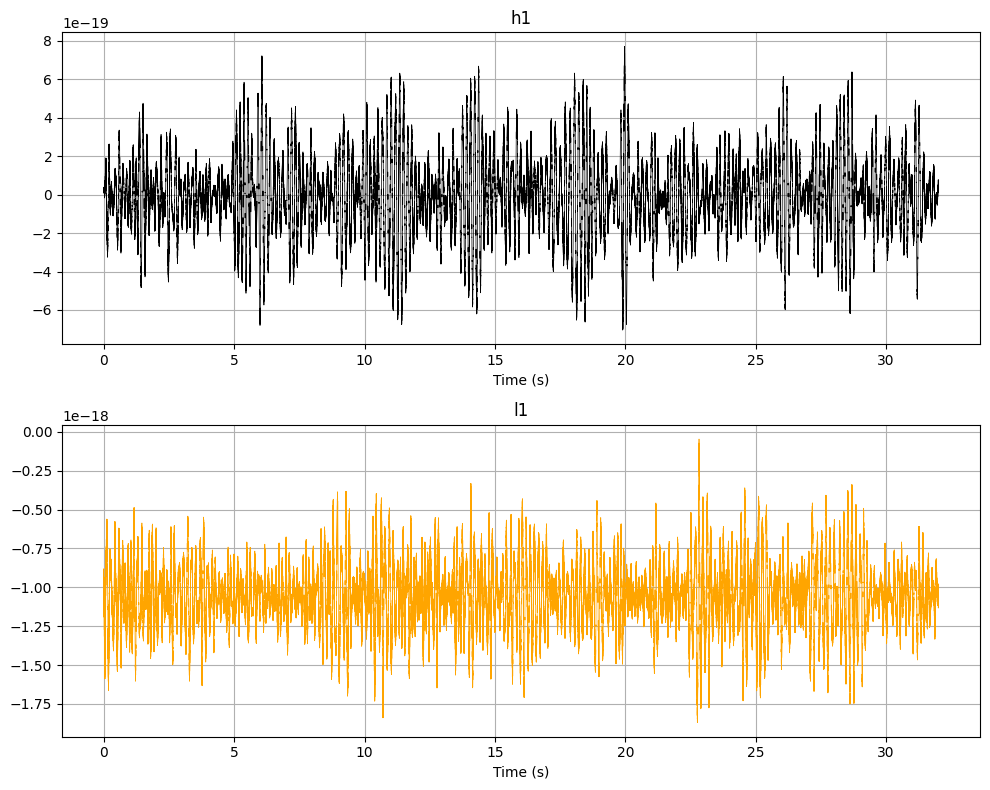

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(time, h1_s, linewidth=0.5, color= "black")
ax1.set_title('h1')
ax1.set_xlabel('Time (s)')

ax2.plot(time, l1_s, linewidth=0.5, color= "orange")
ax2.set_title('l1')
ax2.set_xlabel('Time (s)')

ax1.grid()
ax2.grid()
plt.tight_layout()
plt.show()

Separo una sección del espectro con el evento y analizo despues el ruido por separado

In [9]:
N = 1

#seccion con evento +-1s
h1_gw = h1_s[(time >= gw_st-N) & (time <= gw_st + N)]
l1_gw = l1_s[(time >= gw_st-N) & (time <= gw_st + N)]
time_gw = time[(time >= gw_st-N) & (time <= gw_st + N)]

Visualizo la sección temporal de la señal que incluye al evento. 

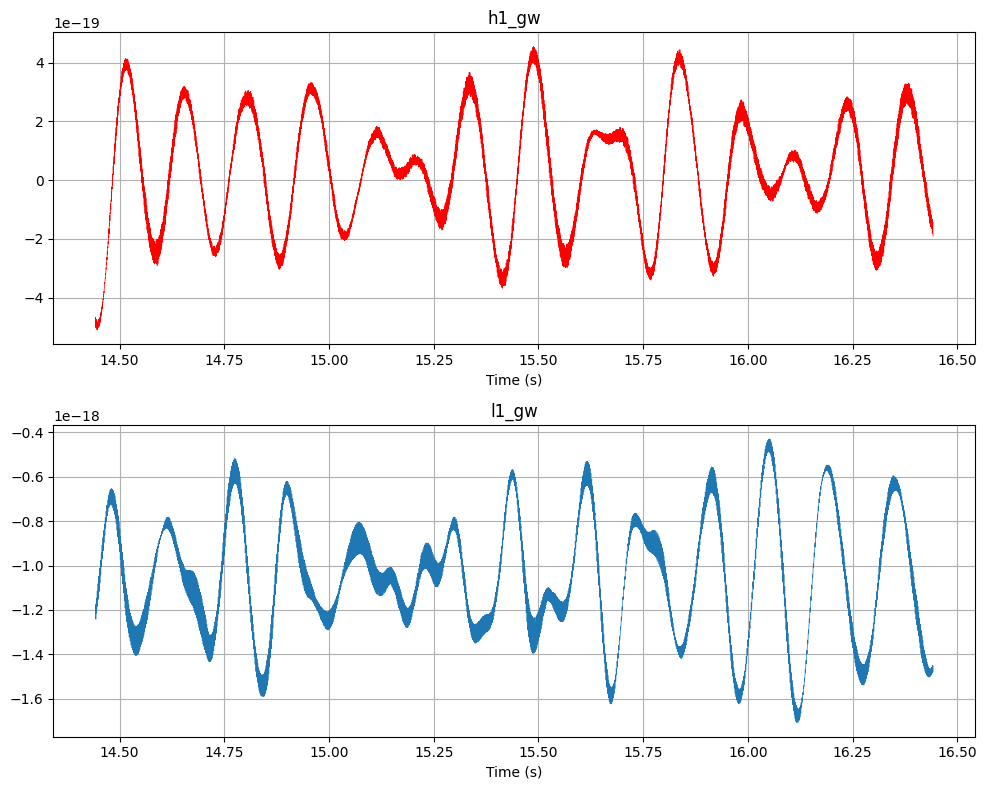

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time_gw, h1_gw, linewidth=0.5, color= "red")
ax1.grid()
ax1.set_title('h1_gw')
ax1.set_xlabel('Time (s)')
ax2.plot(time_gw, l1_gw, linewidth=0.5)
ax2.set_title('l1_gw')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
ax2.grid()
plt.show()

Ahora separo el ruido para estudiar estacionareidad, por ahora voy a trabajar con la cola derecha y luego para el mejor estimador que encuentre utilizaré ambas colas, promediando su espectro. 

In [10]:
#ruido cola derecha

h1_ruido = h1_s[(time > gw_st + N)]
l1_ruido = l1_s[(time > gw_st + N)]
time_ruido = time[(time > gw_st + N)]

#ruido cola izquierda

h1_ruido_2 = h1_s[(time > gw_st + N)]
l1_ruido_2 = l1_s[(time > gw_st + N)]
time_ruido_2 = time[(time > gw_st + N)]

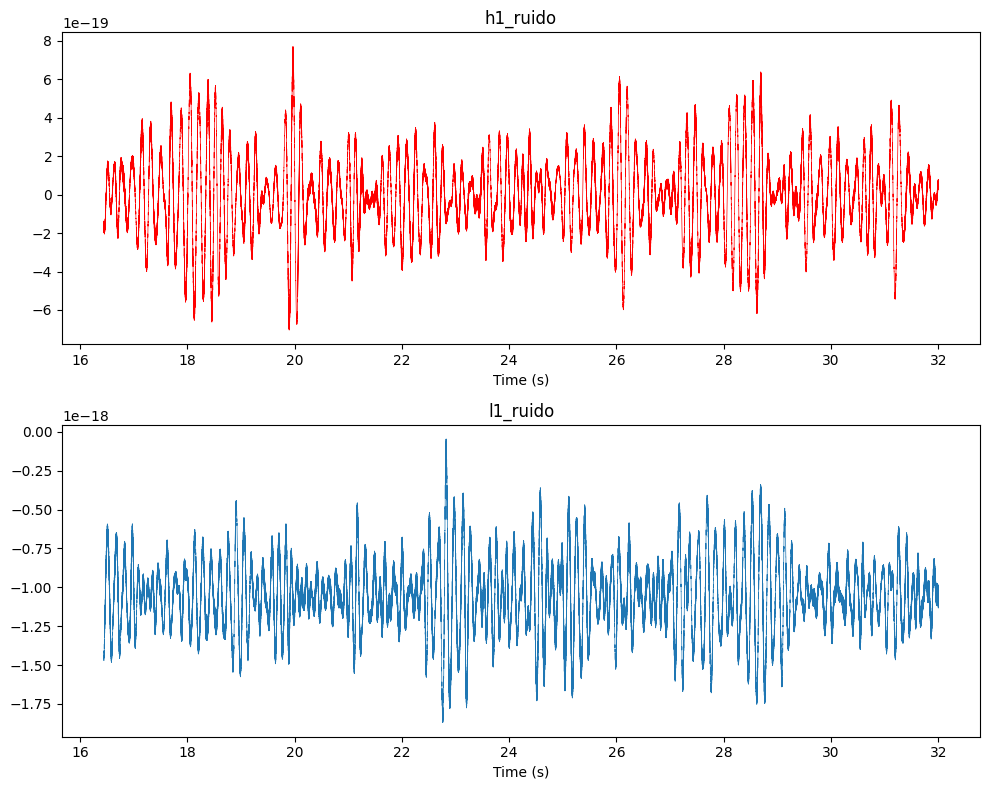

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time_ruido, h1_ruido, linewidth=0.5, color= "red")
ax1.set_title('h1_ruido')
ax1.set_xlabel('Time (s)')

ax2.plot(time_ruido, l1_ruido, linewidth=0.5)
ax2.set_title('l1_ruido')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

TEST DE ESTACIONAREIDAD

Se multiplica por una constante grande, ya que debido a los valores de la señal hace underflow en algunos casos dando resultados erróneo.
Se investiga sobre los diferentes test de estacionareidad ofrecidos por unitroot para determinar que la media 0 no sea una condición, siendo también posible adaptar la tendencia a estudiar según el método.
Un test no alcanza para verificar que sea estacionario, por ello se corren tres pruebas diferentes y al concluir las tres lo mismo, se acepta dicho resultado.

In [5]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("PhillipsPerron Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = KPSS(signal, lags=-1)
  kpss_p_value = kpss_result.pvalue
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [6]:
#Valor significativo: 
alpha = 0.05
#95% de confianza

In [11]:
signal = l1_ruido*1e20
EsEstacionario(signal/np.max(abs(signal)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


In [12]:
signal = h1_ruido*1e20
EsEstacionario(signal/np.max(abs(signal)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


Según los tests aplicados, podemos entonces restar las medias a cada señal.

In [35]:
h1_ruido = h1_ruido - np.mean(h1_ruido)
l1_ruido = l1_ruido - np.mean(l1_ruido)

h1_ruido_2 = h1_ruido - np.mean(h1_ruido)
l1_ruido_2 = l1_ruido - np.mean(l1_ruido)

Periodograma

A continuación se plantea el código para poder llevar a cabo un periodograma o un periodograma modificado de la señal.
Para la autocorrelación se ultilizó la funcion correlate de scipy, ya que utiliza FFT y por lo tanto para arreglos grandes es (mucho) más eficiente que realizar el estimador directamente como en manualautocorr(). En cuanto a la función de periodogram, se hace la fft a la señal ventaneada para aplicar las cuentas dadas en clase.

In [36]:
def periodogram(x, win):
    N = len(x)
    w = scipy.signal.get_window(Nx = N, window = win)
    X = scipy.fft.fft(x*w)
    Rx = X*np.conj(X)/N
    return Rx

def autocorr(x):
    return scipy.signal.correlate(x,x, 'full')/len(x)

def manualautocorr(x, L):
    #L es el lag máximo que quiero computar
    N = len(x)
    rx = np.zeros(N)
    for l in range(L):
        sum = 0
        for i in range(N-l):
            sum += (x[i]*x[i+l])/N
        rx[l]=sum
    rx2 = (rx[1:])[::-1]
    return np.concatenate([rx2, rx])

A modo de analisis exploratorio de los datos graficamos el estimador de autocorrelación de las señales para diferentes lags. 


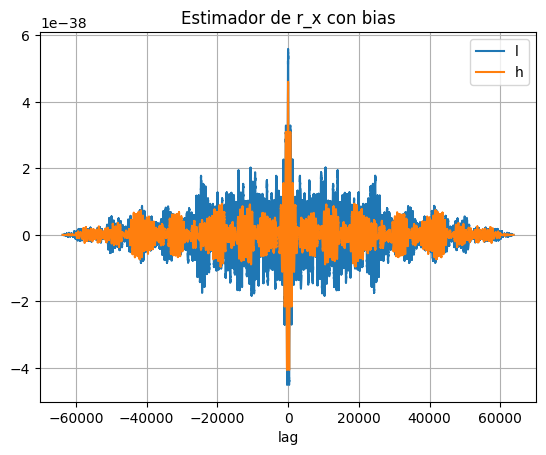

In [37]:
rx_l1 = autocorr(l1_ruido)
rx_h1 = autocorr(h1_ruido)

x_axis = np.array(range(len(rx_h1)))
x_axis = x_axis-len(x_axis)/2-1
plt.plot(x_axis,rx_l1, label = 'l')
plt.plot(x_axis,rx_h1, label = 'h')

plt.xlabel('lag')
plt.legend()
plt.grid()
plt.title('Estimador de r_x con bias')
plt.show()

Luego realizamos un periodograma clásico (es decir, ventaneando los datos con una ventana rectangular). Elegimos tomar la totalidad de los datos para que N sea grande y el valor esperado del periodograma tienda al valor del periodograma real. Sin embargo observamos dos problemas conocidos, primero el periodograma aproximado por el ventaneo de la señal no refleja necesariamente el espectrograma real, ya que a pesar del N grande la varianza es alta. Por otro lado, el mismo tiene un alto grado de leakage espectral. 

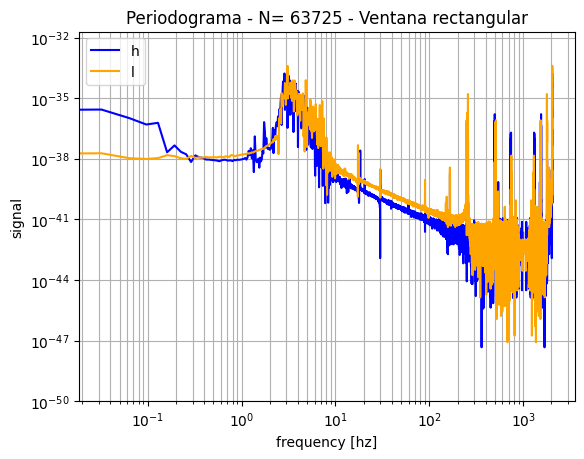

In [62]:
Rx_h = periodogram(h1_ruido, 'boxcar')
Rx_l = periodogram(l1_ruido, 'boxcar')
x_ax = np.linspace(0,0.5, len(Rx_h)) * h1_fs
plt.plot(x_ax, abs(Rx_h), 'blue', label = 'h')
x_ax = np.linspace(0,0.5, len(Rx_l)) * h1_fs
plt.plot(x_ax, abs(Rx_l), 'orange', label = 'l')
plt.title('Periodograma - N= ' + str(len(h1_ruido)) + ' - Ventana rectangular')
plt.grid(True, which= 'both')
plt.xscale("log")
plt.yscale("log")
plt.ylabel('signal')
plt.xlabel('frequency [hz]')
plt.ylim(1e-50)
plt.legend()
plt.show()

A continuación observamos que realizar un periodograma modificado con otra ventana mejora el leakage espectral, pero no resuelve el problema fundamental del periodograma, que es su varianza que no baja al aumentar N. En consecuencia, en los siguientes procedimientos simepre ventanearemos los datos en el tiempo utilizando una ventana de Parzen para mejorar el leakage espectral. Iteramos por varias ventanas, pero elegimos la ventana de Parzen ya que provee un buen piso de ruido. 

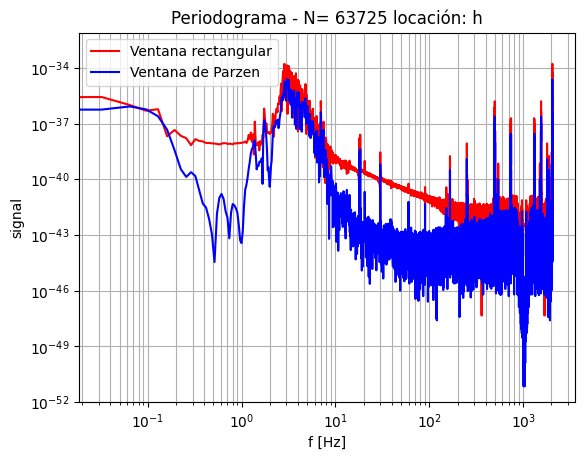

In [63]:
Rx2 = periodogram(h1_ruido, 'boxcar')
x_ax = np.linspace(0,0.5, len(Rx2)) * h1_fs
plt.plot(x_ax, abs(Rx2), 'red', label = 'Ventana rectangular')
Rx = periodogram(h1_ruido, 'parzen')
x_ax = np.linspace(0,0.5, len(Rx)) * h1_fs
plt.plot(x_ax, abs(Rx), 'blue', label = 'Ventana de Parzen')
plt.title('Periodograma - N= ' + str(len(h1_ruido))+ ' locación: h')
plt.grid(True, which= 'both')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.ylim(1e-52)
plt.show()

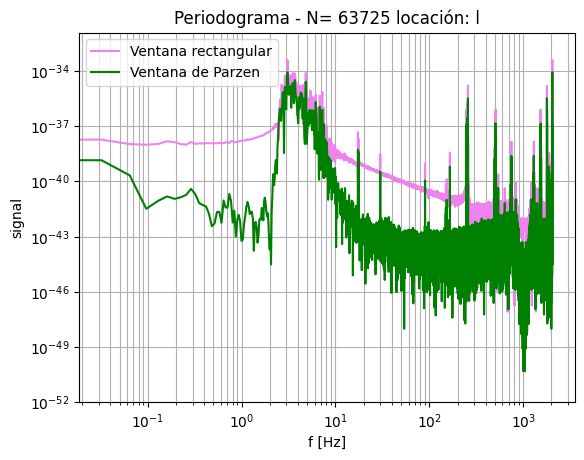

In [67]:
Rx2 = periodogram(l1_ruido, 'boxcar')
x_ax = np.linspace(0,0.5, len(Rx2)) * l1_fs
plt.plot(x_ax, abs(Rx2), 'violet', label = 'Ventana rectangular')
Rx = periodogram(l1_ruido, 'parzen')
x_ax = np.linspace(0,0.5, len(Rx)) * l1_fs
plt.plot(x_ax, abs(Rx), 'green', label = 'Ventana de Parzen')
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.title('Periodograma - N= ' + str(len(h1_ruido))+ ' locación: l')
plt.grid(True, which= 'both')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-52)
plt.legend()
plt.show()

**Periodogram smoothing (Blackman-Tuckey)**

Lo visto en el punto anterior nos lleva a considerar las alternativas para reducir estos problemas. La primera de estas es el enfoque de suavizado del periodograma (periodogram smoothing, o también llamado algoritmo de blackman-tuckey). A continuación se implementa el mismo, de acuerdo a la información brindada por la bibliografía sugerida por la cátedra (Statistical and Adaptive Signal Processing). 

In [41]:

def apply_window(rx, L, win):
    N = len(rx)
    window = scipy.signal.get_window(Nx = 2*L-1, window = win)
    pad_width = int((N-len(window))/2)
    padded_window = np.pad(array = window, pad_width=pad_width)
    return rx*padded_window


def blackman_tuckey(signal, L, w):
    rx = autocorr(signal)
    N = len(signal)
    Rx_smoothing = abs(scipy.fft.fft(apply_window(rx, L, w)))
    return Rx_smoothing[:len(signal)]

En cuanto a la eleccion de las variables para la aplicación de esta técnica, decidimos utilizar una ventana de Parzen ya que evita problemas con la positividad de Rx y, además, produce mejores resultados en cuanto a leakeage espectral que la ventana de Bartlett, que sería la alternativa. 
* Luego, N y L tienen que ser grandes para que el valor esperado de la estimación sea el del periodograma ideal, 
* sin embargo esto presenta un trade-off con la varianza, que disminuye de manera inversamente proporcional a L (y proporcionalmente a N)

Por esto, decidimos nuevamente utilizar un N lo mayor posible para conseguir balancear por un lado la necesidad de resolución y reducir el bias, y por otro lograr un buen smoothing del periodograma. Luego, siguiendo la regla de oro de que L<=N/4 propuesta por Box and Jenkins (1976) decidimos que L = N/8 para que el mismo siga siendo alto (que el bias no crezca).

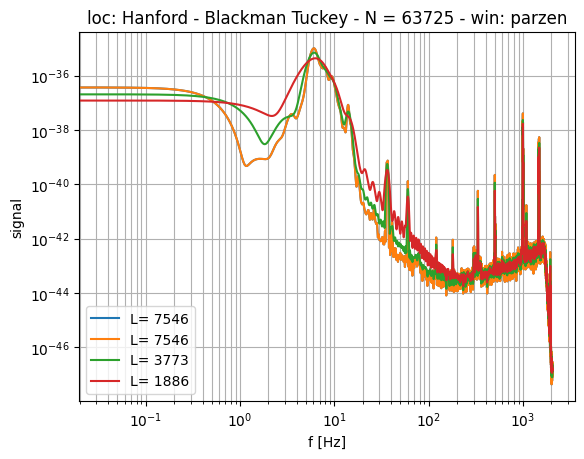

In [42]:
w = 'parzen'

N = 60375
L = int(N/8)

sig = h1_ruido[:N]*scipy.signal.get_window(window = 'parzen', Nx = N)

smoothRx = blackman_tuckey(sig, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs
plt.plot(x_ax, smoothRx, label = 'L= ' + str(L))

N = 60375
L = int(N/8)

sig = h1_ruido[:N]*scipy.signal.get_window(window = 'parzen', Nx = N)

smoothRx = blackman_tuckey(sig, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs
plt.plot(x_ax, smoothRx, label = 'L= ' + str(L))

N = 60375
L = int(N/16)

w = 'parzen'
smoothRx = blackman_tuckey(sig, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs

plt.plot(x_ax, smoothRx, label = 'L= ' + str(L))
plt.title('Blackman Tuckey - N = ' + str(len(h1_ruido)) + ' - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.legend()

N = 60375
L = int(N/32)

w = 'parzen'
smoothRx = blackman_tuckey(sig, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs

plt.plot(x_ax, smoothRx, label = 'L= ' + str(L))
plt.title('loc: Hanford - Blackman Tuckey - N = ' + str(len(h1_ruido)) + ' - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel('f [Hz]')
plt.ylabel('signal')

plt.show()

Entre estos estimadores N/16 nos parece un buen compromiso entre resolución y varianza. A continuación también lo aplicaremos a la segunda seccion de ruido y luego promediaremos los espectros. 

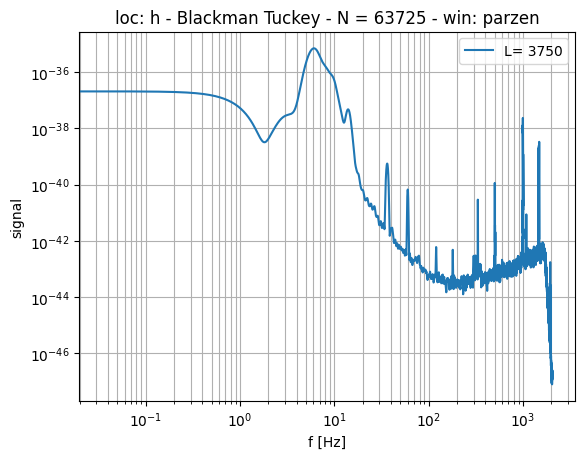

In [43]:
N = 60000
L = int(N/16)
sig1 = h1_ruido[:N]*scipy.signal.get_window(window = 'parzen', Nx = N)
sig2 = h1_ruido_2[:N]*scipy.signal.get_window(window = 'parzen', Nx = N)

w = 'parzen'
smoothRx1 = blackman_tuckey(sig1, L, w)
smoothRx2 = blackman_tuckey(sig2, L, w)
smoothRx = 0.5*(smoothRx1+smoothRx2)

x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs

plt.plot(x_ax, smoothRx, label = 'L= ' + str(L))
plt.title('loc: Hanford - Blackman Tuckey - N = ' + str(len(h1_ruido)) + ' - win: ' + w)


plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.show()

Luego realizamos lo propio para la locacion l.

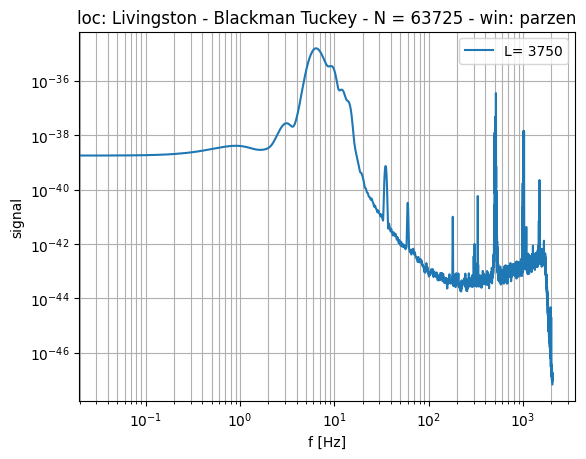

In [44]:
N = 60000
L = int(N/16)
sig1 = l1_ruido[:N]*scipy.signal.get_window(window = 'parzen', Nx = N)
sig2 = l1_ruido_2[:N]*scipy.signal.get_window(window = 'parzen', Nx = N)

w = 'parzen'
smoothRx1 = blackman_tuckey(sig1, L, w)
smoothRx2 = blackman_tuckey(sig2, L, w)
smoothRx = 0.5*(smoothRx1+smoothRx2)


x_ax = np.linspace(0,0.5, len(smoothRx)) * l1_fs

plt.plot(x_ax, smoothRx, label = 'L= ' + str(L))


plt.title('loc: Livingston - Blackman Tuckey - N = ' + str(len(l1_ruido)) + ' - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.legend()
plt.show()

**Periodogram averaging: Welch-Bartlett**

Finalmente, probamos otra técnica para suavizar el periodograma, el promediado (también llamado algoritmo de Welch-Bartlett). Esta consta de la subdivisión de las muestras tomadas en el tiempo en diferentes secciones, opcionalmente con cierto overlap. A continuación planteamos las funciones necesarias para hacer lo propuesto. Hay que notar que en nuestra función K (la cantidad de segmentos promediados) no se selecciona directamente, sino indirectamente a través del tamaño de los segmentos y el overlap deseado. 

In [45]:
def welch_bartlett(signal, w, segment_size, overlap = 0):

    X_prom = np.zeros(segment_size)
    N = len(signal)
    i=0
    segment_count = 0
    d = int(segment_size*(1-overlap))
    while i+segment_size<N:
        segment = signal[i:i+segment_size]
        s_len = len(segment)
        Xr = abs(scipy.fft.fft(segment*scipy.signal.get_window(Nx = s_len, window = w)))
        X_prom += np.power(Xr, 2)
        i=i+d
        segment_count+=1


    X_prom /= (segment_count*segment_size)

    return X_prom[:int(segment_size/2)]

Luego, procedemos a realizar una estimación de Rx con esta técnica. Como en el caso anterior, utilizamos segmentos lo más largos posible para poder disminuir en mayor medida la varianza. Ya que un mayor N permite aumentar el K sin perder tanta resolución. Además se optó por un overlap del 50% para poder disminuir la varianza del estimador en un factor de  1/2K en lugar de 1/K. Además, se probaron diferentes tamaños de segmentos para el promediado (L aquí se refiere al tamaño de los segmentos). En definitiva elegimos N/16 ya que provee un buen balance entre resolución y disminución de varianza.   

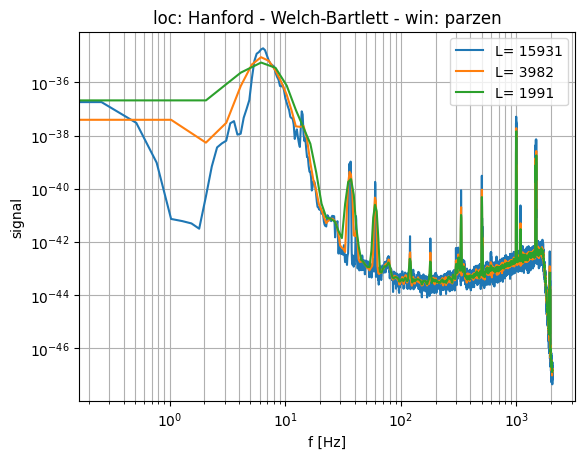

In [46]:
w = 'parzen'

L = int(len(h1_ruido)/4)
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax,Rx_pa, label = 'L= '+str(L))
plt.title('loc: Hanford - Welch-Bartlett - win: ' + w)


w = 'parzen'
L = int(len(h1_ruido)/16)
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax,Rx_pa, label = 'L= '+str(L))


w = 'parzen'
L = int(len(h1_ruido)/32)
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax, Rx_pa, label = 'L= '+str(L))

plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.show()

Al igual que antes, tomamos el estimajor que más nos satisfizo (L = N/16 y overlap 50%)

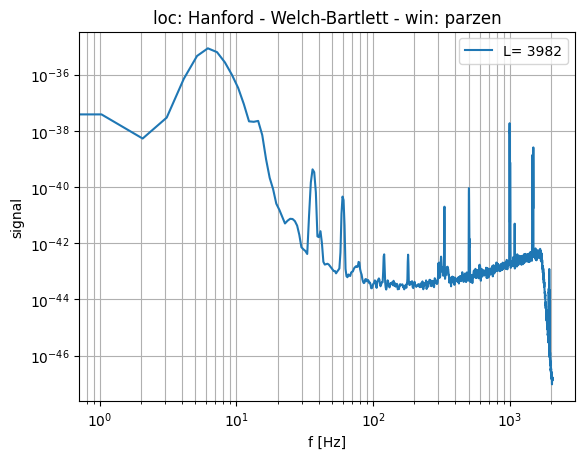

In [47]:
w = 'parzen'

w = 'parzen'
L = int(len(h1_ruido)/16)

Rx_pa_1 = welch_bartlett(h1_ruido, w, L, overlap=0.5)
Rx_pa_2 = welch_bartlett(h1_ruido_2, w, L, overlap=0.5)
Rx_pa = 0.5*(Rx_pa_1+Rx_pa_2)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax,Rx_pa, label = 'L= '+str(L))

plt.title('loc: Hanford - Welch-Bartlett - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.show()

Rx_pa_h = Rx_pa

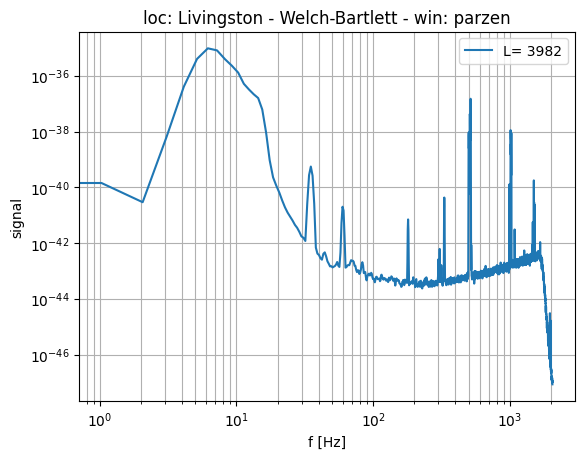

In [48]:
w = 'parzen'

w = 'parzen'
L = int(len(l1_ruido)/16)

Rx_pa_1 = welch_bartlett(l1_ruido, w, L, overlap=0.5)
Rx_pa_2 = welch_bartlett(l1_ruido_2, w, L, overlap=0.5)
Rx_pa = 0.5*(Rx_pa_1+Rx_pa_2)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * l1_fs
plt.plot(x_ax,Rx_pa, label = 'L= '+str(L))

plt.title('loc: Livingston - Welch-Bartlett - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.show()

Rx_pa_l = Rx_pa

**Whitenning**

De los metodos analizados la solución que más nos convenció fue el promediado de periodogramas ya que permitió disminuir la varianza en mayor medida utilizando la misma cantidad de datos y sin perder resolución en las zonas de frecuencia relevantes al proceso gracias a la utilización de un overlap grande.

In [49]:
h1p_p = Rx_pa_h
h1p_f = np.linspace(0,0.5, len(h1p_p)) * h1_fs

l1p_p = Rx_pa_l
l1p_f = np.linspace(0,0.5, len(l1p_p)) * l1_fs

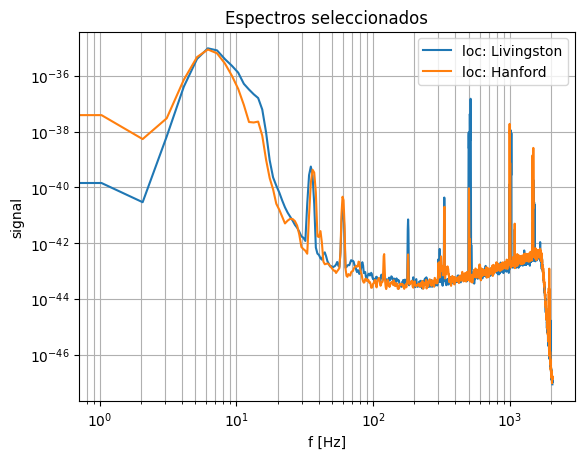

In [50]:
plt.plot(l1p_f, l1p_p, label = 'loc: Livingston')
plt.plot(h1p_f, h1p_p, label = 'loc: Hanford')


plt.title('Espectros seleccionados')
plt.xlabel('f [Hz]')
plt.ylabel('signal')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both")

Observamos que según nuestro análisis las zonas de zuido marcadas por LIGO se cumplen. Tenemos una acumulación de ruido por debajo de los 100Hz que se puede deber a una multitud de factores como el gradiente gravitacional, suspensión térmica y presión de radiación y que, probablemente, se deba a una acumulación de estos. Por encima de esta frecuencia tenemos una serie de picos. Es notorio que los espectros de ruido son muy similares, aunque la señal en Livingstone presenta picos de ruido mayores que Hanford.

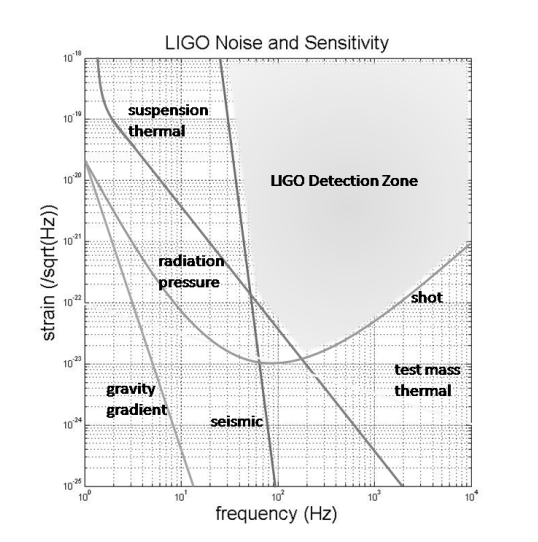



In [51]:
print(h1p_f.shape)
print(h1p_p.shape)

h1_psd = interp1d(h1p_f, h1p_p, kind='nearest', bounds_error=False, assume_sorted=True)
l1_psd = interp1d(l1p_f, l1p_p, kind='nearest', bounds_error=False, assume_sorted=True)

(1991,)
(1991,)


In [52]:

h1_psd = np.abs(h1_psd(np.fft.rfftfreq(len(h1_s), 1/h1_fs)))**2
l1_psd = np.abs(l1_psd(np.fft.rfftfreq(len(l1_s), 1/l1_fs)))**2

# Signal whitening
h1_w = np.fft.irfft(np.fft.rfft(h1_s) / np.sqrt(h1_psd))
l1_w = np.fft.irfft(np.fft.rfft(l1_s) / np.sqrt(l1_psd))

In [53]:
nyqh = 0.5 * h1_fs
low_h = 30
high_h = 300
lowh = low_h / nyqh
highh = high_h / nyqh
bh, ah = butter(6, [lowh, highh], btype='band')

nyql = 0.5 * l1_fs
low_l = 20
high_l = 300
lowl = low_l / nyql
highl = high_l / nyql
bl, al = butter(6, [lowl, highl], btype='band')

# Apply passband filter
h1_f_w = lfilter(bh, ah, h1_w)
l1_f_w = lfilter(bl, al, l1_w)

In [54]:

wav_interval = (time > gw_st - 2) & (time < gw_st + 2)
#Scale signal to fit WAV format
h1_gw_fin = np.int16(h1_f_w[wav_interval]/np.max(np.abs(h1_f_w[wav_interval])) * 32767 * 0.9)
l1_gw_fin = np.int16(l1_f_w[wav_interval]/np.max(np.abs(l1_f_w[wav_interval])) * 32767 * 0.9)
scipy.io.wavfile.write('h1_gw.wav', int(h1_fs), h1_gw_fin)
scipy.io.wavfile.write('l1_gw.wav', int(l1_fs), l1_gw_fin)

Luego del filtrado podemos escuchar nuestras señales del evento gravitacional:

In [55]:
from pydub import AudioSegment
from numpy.random import uniform
filename = "h1_gw.wav"
sound = AudioSegment.from_file(filename, format=filename[-3:])

octaves = 0.5
for octaves in np.linspace(-1,1,21):
    new_sample_rate = int(sound.frame_rate * (2.0 ** octaves))
    hipitch_sound = sound._spawn(sound.raw_data, overrides={'frame_rate': new_sample_rate})
    hipitch_sound = hipitch_sound.set_frame_rate(44100)
    hipitch_sound.export(f"filename_upshifted.wav", format="wav")

audio = Audio("filename_upshifted.wav")


display(audio)


In [56]:
from pydub import AudioSegment
from numpy.random import uniform
filename = "l1_gw.wav"
sound = AudioSegment.from_file(filename, format=filename[-3:])

octaves = 0.5
for octaves in np.linspace(-1,1,21):
    new_sample_rate = int(sound.frame_rate * (2.0 ** octaves))
    hipitch_sound = sound._spawn(sound.raw_data, overrides={'frame_rate': new_sample_rate})
    hipitch_sound = hipitch_sound.set_frame_rate(44100)
    hipitch_sound.export(f"filename_upshifted.wav", format="wav")

audio = Audio("filename_upshifted.wav")


display(audio)

Luego realizamos la correlación cruzada para poder determinar la diferencia temporal del evento en ambas locaciones.

In [57]:
interval = (time > gw_st - 0.1) & (time < gw_st + 0.1)
N = len(h1_f_w[interval])
x_corr = scipy.correlate(h1_f_w[interval], -l1_f_w[interval], 'full')

C:\Users\joaco\AppData\Local\Temp\ipykernel_1452\2712613451.py:3: DeprecationWarning: scipy.correlate is deprecated and will be removed in SciPy 2.0.0, use numpy.correlate instead
  x_corr = scipy.correlate(h1_f_w[interval], -l1_f_w[interval], 'full')


In [70]:
deltaT = (np.argmax(x_corr)-N)/h1_fs * 1e3
print(deltaT, 'ms')

6.8359375 ms


Y finalmente calculamos el ángulo del cono de aproximación:

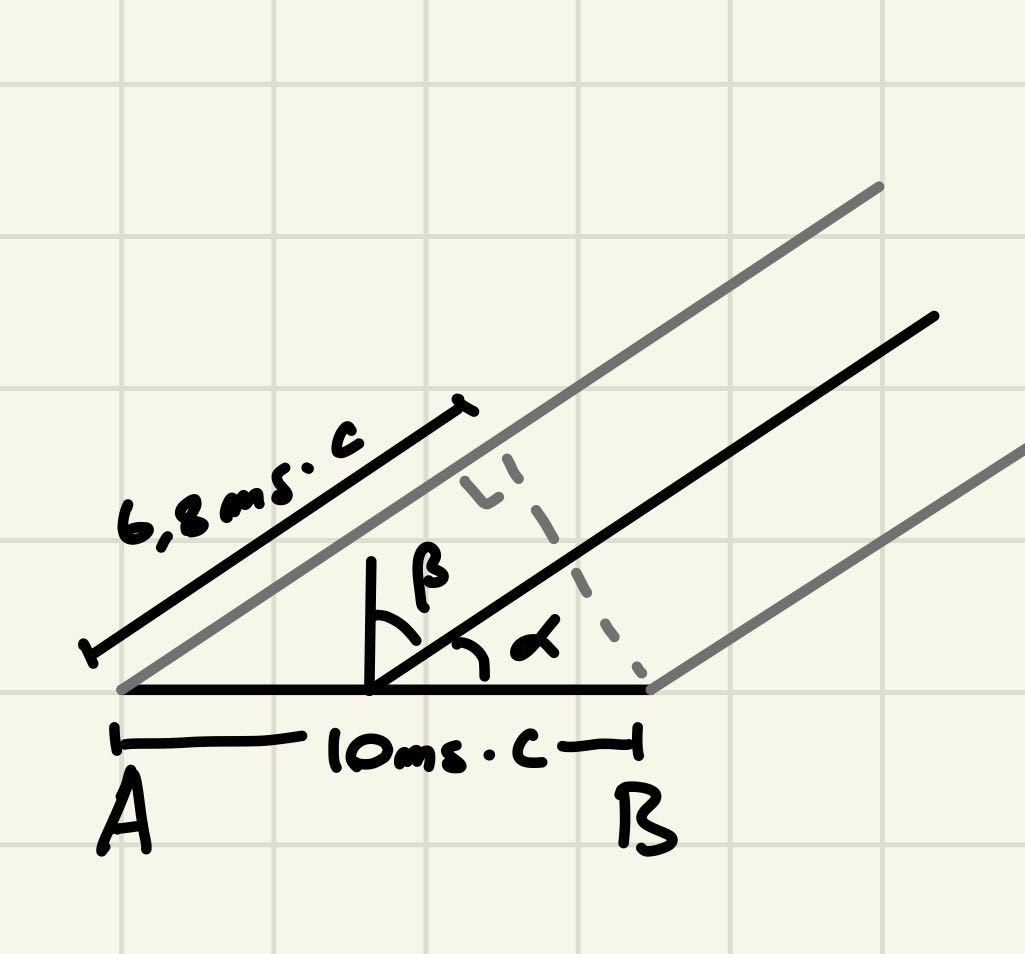

In [69]:
alpha = 360*np.arccos(deltaT/10)/(2*np.pi)
beta = 90-alpha

print('alpha =', alpha, '°')
print('beta =', beta, '°')

alpha = 46.87488633081353 °
beta = 43.12511366918647 °
